In [1]:
import sys
sys.path.append('../..')

In [2]:
from src.models import MLP
from torchvision.datasets import MNIST
from typing import Union
import pandas as pd
import numpy as np
import torch
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.utils import make_performance_uncertainty_plot
from sklearn.metrics import roc_auc_score

In [3]:
torch.manual_seed(42)

In [4]:
mnist_train = MNIST('../../data/', download=True)
mnist_test = MNIST('../../data/', download=True)

In [5]:
mnist_train.data[mnist_train.targets == 0].shape

torch.Size([5923, 28, 28])

In [6]:
# Select (arbitrarily) 0 (negative) and 1 (positive) as binary classification problem.
binary_mnist_train_data = mnist_train.data[(mnist_train.targets == 0) | (mnist_train.targets == 1)]
binary_mnist_test_data = mnist_test.data[(mnist_test.targets == 0) | (mnist_test.targets == 1)]

binary_mnist_train_targets = mnist_train.targets[(mnist_train.targets == 0) | (mnist_train.targets == 1)]
binary_mnist_test_targets = mnist_test.targets[(mnist_test.targets == 0) | (mnist_test.targets == 1)]

In [7]:
model_canonical = MLP(28 * 28, 1, class_weights=[1, 1])
# Overconfident model, predicts 1 more often.
model_confident = MLP(28 * 28, 1, class_weights=[1, 2])
# Shy model, predicts 0 more often.
model_diffident = MLP(28 * 28, 1, class_weights=[1, 0.5])

In [8]:
def get_dataloader_from_tensors(X: torch.Tensor, y: torch.Tensor, batch_size: int,
                                shuffle: bool = True) -> DataLoader:
    """Obtain a dataloader for training/testing from input Tensors.

    Parameters
    ----------
    X: torch.Tensor
        data
    y: torch.Tensor
        labels
    batch_size: int
        batch_size
    shuffle: optional, bool
        Whether or not to shuffle the data first.

    Returns
    -------
    DataLoader
    """

    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size, shuffle)

    return loader


def _convert_to_tensor(X: Union[pd.Series, pd.DataFrame, np.ndarray]) -> torch.Tensor:
    """Convert pandas instance or numpy array to torch.Tensor

    Parameters
    ----------
    X: Input dataframe or series.

    Returns
    -------
    torch.Tensor
        Converted to torch.Tensor
    """
    
    if not isinstance(X, torch.Tensor):
        # Convert dataframes to numpy arrays.
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values

        # Convert arrays to Tensors.
        X = torch.from_numpy(X)
    
    X = X.float()
        
    return X

def fit(model,
        X: Union[np.ndarray, pd.DataFrame],
        y: Union[np.ndarray, pd.Series],
        epochs: int = 256,
        lr: float = 1e-3,
        batch_size: int = 128,
        val_batch_size: int = 512,
        validate: bool = False,
        X_val: Union[np.ndarray, pd.DataFrame] = None,
        y_val: Union[np.ndarray, pd.Series] = None,
        verbose: bool = True,
        tensorboard: bool = False,
        early_stopping_patience: int = None):
    """Fit the BNN to a dataset.

    Parameters
    ----------
    X: Union[np.ndarray, pd.DataFrame]
        Training data.
    y: Union[np.ndarray, pd.Series]
        Training labels.
    lr: float
        Learning rate.
    alpha: float
        The size of the prediction loss compared to the KL-loss.
    validate: bool
        Whether or not to run validation to monitor performance.
    X_val: Union[np.ndarray, pd.DataFrame],  optional
        Validation data
    y_val: Union[np.ndarray, pd.DataFrame], optional
        Validation labels
    verbose: bool
        Print performance metrics?

    Returns
    -------
    BNNClassifier
    """

    if early_stopping_patience is not None and not validate:
        raise ValueError("Provide validation data to early stop on!")

    # Convert inputs to tensors.
    X, y = _convert_to_tensor(X), _convert_to_tensor(y)

    X = X.reshape(X.shape[0], -1)

    if validate:
        if X_val is None or y_val is None:
            raise ValueError("No validation data provided!")

        X_val, y_val = _convert_to_tensor(X_val), _convert_to_tensor(y_val)
        X_val = X_val.reshape(X_val.shape[0], -1)

    if model.n_classes > 1:
        y, y_val = y.long(), y_val.long()

    # Get the optimizer. (Note: can't get SGD to converge on MNIST?)
    optimizer = Adam(model.parameters(), lr=lr)

    # Initialize dataloader.
    train_loader = get_dataloader_from_tensors(X, y, batch_size)

    if validate:
        test_loader = get_dataloader_from_tensors(X_val, y_val, val_batch_size)

    if tensorboard:
        writer = SummaryWriter(model.tensorboard_logdir)
    else:
        writer = None

    if early_stopping_patience is not None:
        best_loss = 1e9  # Large number placeholder
        patience = 0

    # Train
    for epoch in tqdm(range(epochs), position=0):
        model.fit(optimizer, epoch, train_loader, writer=writer)

        if validate:
            performance_dict = model.validate(epoch,
                                                 train_loader, test_loader, writer=writer, verbose=verbose)

            if early_stopping_patience is not None:

                if round(performance_dict['loss'], 2) <= round(best_loss, 2):
                    best_loss = performance_dict['loss']
                    patience = 0
                    best_parameters = model.state_dict()
                    torch.save(best_parameters, 'tmp.pth')

                else:
                    patience += 1

                if patience == early_stopping_patience:
                    print("Loading saved parameters..")
                    model.eval()
                    model.load_state_dict(torch.load('tmp.pth'))
                    os.remove('tmp.pth')
                    break

    return model


In [9]:
fit(model_canonical, 
    binary_mnist_train_data, 
    binary_mnist_train_targets, 
    validate=True,
    lr=1e-3,
    X_val=binary_mnist_test_data,
    y_val=binary_mnist_test_targets,
    early_stopping_patience=8,
    epochs=1)

Epoch: 0 | Total Loss: 2.6145 | 



MLP(
  (f): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
  (nll): BCEWithLogitsLoss()
)

In [10]:
fit(model_confident, 
    binary_mnist_train_data, 
    binary_mnist_train_targets, 
    validate=True,
    lr=1e-3,
    X_val=binary_mnist_test_data,
    y_val=binary_mnist_test_targets,
    early_stopping_patience=8,
    epochs=1)

Epoch: 0 | Total Loss: 3.0506 | 



MLP(
  (f): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
  (nll): BCEWithLogitsLoss()
)

In [11]:
fit(model_diffident, 
    binary_mnist_train_data, 
    binary_mnist_train_targets, 
    validate=True,
    lr=1e-3,
    X_val=binary_mnist_test_data,
    y_val=binary_mnist_test_targets,
    early_stopping_patience=8,
    epochs=1)

Epoch: 0 | Total Loss: 2.0765 | 



MLP(
  (f): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
  (nll): BCEWithLogitsLoss()
)

In [12]:
with torch.no_grad():
    predictions_canonical = torch.sigmoid(model_canonical(binary_mnist_test_data.float())).squeeze()


    predictions_confident = torch.sigmoid(model_confident(binary_mnist_test_data.float())).squeeze()

    predictions_diffident = torch.sigmoid(model_diffident(binary_mnist_test_data.float())).squeeze()

In [13]:
# should these be absolute values?

uncertainties_logit = torch.log((predictions_confident - predictions_diffident) 
                          / (1 - predictions_confident - predictions_diffident))

uncertainties_probit = predictions_confident - predictions_diffident

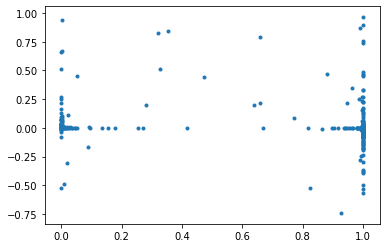

In [14]:
plt.scatter(predictions_canonical.squeeze().numpy(), uncertainties_probit.squeeze().numpy(), marker='.')

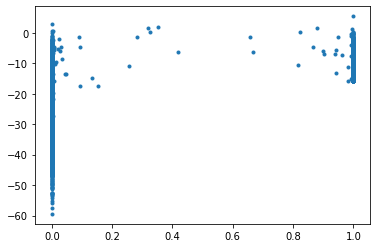

In [15]:
plt.scatter(predictions_canonical.squeeze().numpy(), uncertainties_logit.squeeze().numpy(), marker='.')

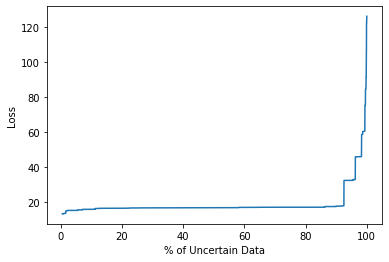

In [16]:
fig = make_performance_uncertainty_plot(binary_mnist_test_targets.numpy(), predictions_canonical.numpy(), uncertainties_probit.numpy(),
                                  y_axis_label='Loss', performance_fn_args={'reduction': 'sum'})

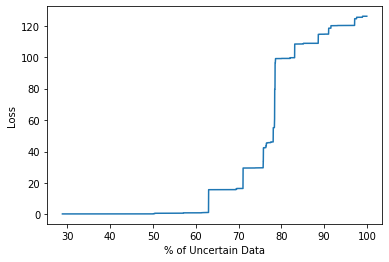

In [17]:
fig = make_performance_uncertainty_plot(binary_mnist_test_targets.numpy(), predictions_canonical.numpy(), uncertainties_logit.numpy(),
                                  y_axis_label='Loss', performance_fn_args={'reduction': 'sum'})

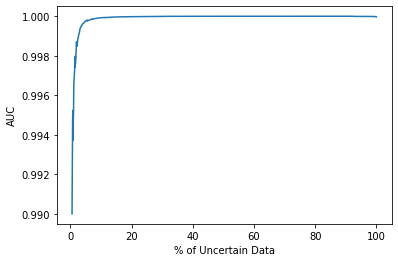

In [18]:
fig = make_performance_uncertainty_plot(binary_mnist_test_targets.numpy(), predictions_canonical.numpy(), uncertainties_probit.numpy(),
                                  y_axis_label='AUC', performance_fn=roc_auc_score)

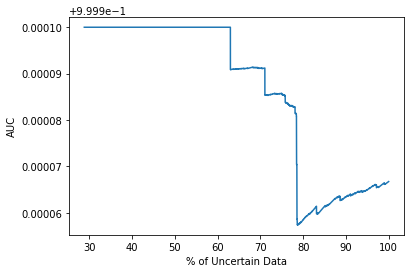

In [19]:
fig = make_performance_uncertainty_plot(binary_mnist_test_targets.numpy(), predictions_canonical.numpy(), uncertainties_logit.numpy(),
                                  y_axis_label='AUC', performance_fn=roc_auc_score)